In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  !git config --global user.email "naiaseh@uwo.com"
  !git config --global user.name "Nadia Aiaseh"

In [6]:
import os
os.chdir("/content/drive/MyDrive/Trunk/PinnNew")
print(os.getcwdb())

b'/content/drive/MyDrive/Trunk/PinnNew'


In [ ]:
!git add KP.ipynb
!git commit -m "Yconfig solution (somewhat) convergence"
!git push origin main

[main c831675] Yconfig solution (somewhat) convergence
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite PinnNew/KP.ipynb (62%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 8 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.25 MiB | 2.92 MiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/naiaseh/Trunk.git
   a74ca63..c831675  main -> main


In [ ]:
!git add KPXConfig.ipynb
!git commit -m "XConfig seq-2-seq"
!git push origin main

In [7]:
from modules.models import KPPinn, create_dense_model, create_dense_model_Normalized, FourierFeatures
from modules.data import simulate_KP
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import imageio

In [2]:

phi = 0



def boundary_function(txy):
    return phi*tf.ones_like(txy[:, 1:2])




In [11]:

x_start =  -20.
length = 20.
y_start = x_start
ylength = length
t0 = 0.
time = 4.

def phi_function2(txy):

  k1 = 1/2.
  k2 = 1/2.
  c = k1**2*4
  c2 = k2**2*4

  # for X config set both to 22
  offset =  22.
  offset2 =  22.



  vert_offset1, vert_offset2 =  0., 0.



  lamb = 2./3. # if this is negative it'll be CW
  lamb2 = -2./3.

  eta1 = k1*((txy[:, 1:2] + offset) + lamb * (txy[:,2:3] + vert_offset1) - (k1**2+3*lamb**2) *txy[:,0:1] )
  eta2 = k2*((txy[:, 1:2] + offset2) + lamb2 * (txy[:,2:3] + vert_offset2) - (k2**2+3*lamb2**2) * txy[:,0:1])


  eA12 =( (k1-k2)**2 - (lamb-lamb2)**2)/((k1+k2)**2 - (lamb-lamb2)**2)
  # print('eA12',eA12)
  # eA23 =( (k2-k3)**2 - (lamb2-lamb3)**2)/((k2+k3)**2 - (lamb2-lamb3)**2)

  deriv_term1 = (k1**2 * tf.math.exp(eta1) + k2**2 * tf.math.exp(eta2) + eA12 * (k1+k2)**2 * tf.math.exp(eta1+eta2)) / (1 + tf.math.exp(eta1) + tf.math.exp(eta2) + eA12 * tf.math.exp(eta1+eta2))
  deriv_term2 = (k1 * tf.math.exp(eta1) + k2 * tf.math.exp(eta2) + eA12 * (k1+k2) * tf.math.exp(eta1+eta2))**2 / (1 + tf.math.exp(eta1) + tf.math.exp(eta2) + eA12 * tf.math.exp(eta1+eta2))**2

  u2 = 2*(deriv_term1 - deriv_term2)
  u2 = tf.where(tf.math.is_nan(u2), 0., u2)

  return u2



(300, 3)
my shape tf.Tensor([90000     1], shape=(2,), dtype=int32) tf.Tensor([300 300], shape=(2,), dtype=int32)


Text(0.5, 1.0, 'wave cross section at y = 0')

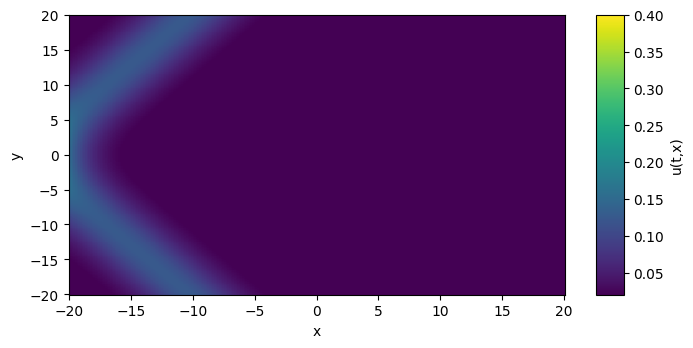

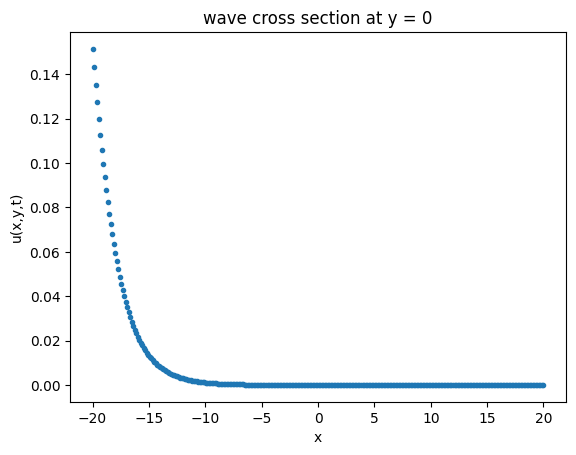

In [12]:
from matplotlib.gridspec import GridSpec
N = 300
TIME = 0.
xt = np.linspace(x_start,length,N).T
yt = np.linspace(y_start,ylength,N).T
tt = np.zeros((N,1))
xt = xt.reshape(-1,1)
yt = yt.reshape(-1,1)
tt = tt.reshape(-1,1)

txy_test = np.c_[tt,xt,yt]
print(txy_test.shape)
txy_test = tf.convert_to_tensor(txy_test, dtype = 'float32')
txy_test = tf.reshape(txy_test, [N,3])

x, y = np.meshgrid(xt, yt)
txy = np.stack([np.full(x.flatten().shape, TIME), x.flatten(), y.flatten()],axis=-1)
fig = plt.figure(figsize=(8,8))

gs = GridSpec(2, 5)
plt.subplot(gs[0, :])

ut = phi_function2(txy)
print('my shape',tf.shape(ut), tf.shape(x))
ut = tf.reshape(ut, [x.shape[0],x.shape[1]])
plt.pcolormesh(x, y, ut)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
# cbar.mappable.set_clim( tf.reduce_min(ut), tf.reduce_max(ut))
cbar.mappable.set_clim( 0.02, 0.4)
fig = plt.figure()

cross_sect = 0

txy2 = np.stack([np.full(tt.shape, TIME),  xt , np.full(tt.shape, cross_sect)], axis=1)
u2 = phi_function2(txy2)
u2 = tf.reshape(u2, [xt.shape[0],xt.shape[1]])
plt.plot(xt, u2, '.',label = 'exact at time {}'.format(0))

plt.xlabel('x')
plt.ylabel('u(x,y,t)')
plt.title('wave cross section at y = {}'.format(cross_sect))

In [13]:
# when boundary function is set to None, the data will be collected from the phi_function but at boundary
(txy_eqn, u_eqn), (txy_init, u_phi), (txy_boundary_x, u_bnd_x), (txy_boundary_y, u_bnd_y), (x_bnd_left, x_bnd_right), (y_bnd_left, y_bnd_right)  = simulate_KP(1000000, phi_function2, None, time, x_start, length, y_start, ylength, n_bnds = None,\
                                                                                                                                                               n_init = None, tstart = t0, random_seed = 42, dtype=tf.float32)

In [14]:
normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(txy_eqn)
# normalizer = FourierFeatures(n_features=25, standard_dev = 5.)
# normalizer.build(input_shape=[3])


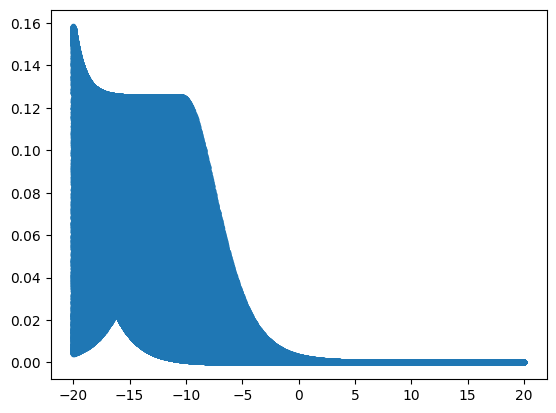

In [15]:
# plt.plot(txy_boundary_x[:,1:2],u_bnd_x,'.')

plt.plot(txy_init[:,1:2],u_phi,'.')

inputs = [txy_eqn, txy_init, txy_boundary_x, x_bnd_right, x_bnd_left, txy_boundary_y, y_bnd_right, y_bnd_left]
outputs = [phi_function2(txy_eqn), u_eqn, u_phi, u_bnd_x, u_bnd_y]


In [ ]:
print(tf.shape(txy_eqn))

tf.Tensor([50000     3], shape=(2,), dtype=int32)


In [18]:
### another network structure that worked well was [12, 24, 24, 24, 12] ###
backbone = create_dense_model_Normalized([12, 24, 24, 24, 24, 12] , activation= 'tanh', initializer='glorot_normal', \
    n_inputs=3, n_outputs=1, normalizer=normalizer)
pinn = KPPinn(backbone, k=6., sig_sq = +3., PBC_y = False)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.85)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)

In [19]:
history = pinn.fit(inputs, outputs, batch_size= 75000, epochs = 800, verbose = 1)

Epoch 1/800
14/14 [==============================] - 55s 100ms/step - loss_total: 0.0805 - loss_residual: 2.0243e-05 - loss_initial: 0.0278 - loss_boundary: 0.0238 - loss_boundary_y: 0.0288 - mean_absolute_error: 0.1158
Epoch 2/800
14/14 [==============================] - 1s 98ms/step - loss_total: 0.0130 - loss_residual: 4.5606e-06 - loss_initial: 0.0032 - loss_boundary: 0.0051 - loss_boundary_y: 0.0047 - mean_absolute_error: 0.0541
Epoch 3/800
14/14 [==============================] - 1s 99ms/step - loss_total: 0.0069 - loss_residual: 2.9030e-06 - loss_initial: 0.0010 - loss_boundary: 0.0042 - loss_boundary_y: 0.0017 - mean_absolute_error: 0.0365
Epoch 4/800
14/14 [==============================] - 1s 98ms/step - loss_total: 0.0057 - loss_residual: 2.2302e-06 - loss_initial: 8.5027e-04 - loss_boundary: 0.0034 - loss_boundary_y: 0.0014 - mean_absolute_error: 0.0299
Epoch 5/800
14/14 [==============================] - 1s 97ms/step - loss_total: 0.0052 - loss_residual: 2.4240e-06 - loss_

In [ ]:
# to set
with open('', 'rb') as f:
    my_weights = pickle.load(f)

pinn.backbone.set_weights(my_weights)

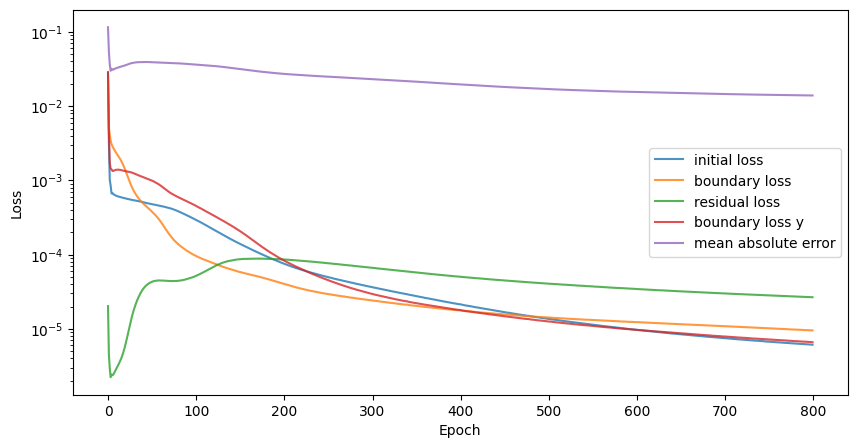

In [20]:
plot_training_loss(history.history, y_scale='log')

In [21]:
from matplotlib.gridspec import GridSpec
def plot_snapshots(timeList,num_test_samples = 200, phi_function = None, cross_sect = 0):

    x_flat = np.linspace(x_start, length, num_test_samples)
    y_flat = np.linspace(y_start, ylength, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    y_flat = tf.convert_to_tensor(y_flat)
    t_flat = tf.convert_to_tensor(t_flat)

    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        x, y = np.meshgrid(x_flat, y_flat)
        txy = np.stack([np.full(x.flatten().shape, t_cs), x.flatten(), y.flatten()],axis=-1)


        fig = plt.figure(figsize=(7,4))
        gs = GridSpec(2, 5)
        plt.subplot(gs[0, :])

        u = pinn.backbone.predict(txy, batch_size=num_test_samples)
        u = u.reshape(x.shape)
        plt.pcolormesh(x, y, u)
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar(pad=0.05, aspect=10)
        cbar.set_label('u(t,x)')
        cbar.mappable.set_clim(0., 0.3)
        # cbar.mappable.set_clim(tf.reduce_min(u), tf.reduce_max(u))
        # plt.savefig(str(os.getcwdb())[2:-1]+"/GIFs/KPIIXJunctionTime15PDF/KPIIXJunction"+str(i)+".pdf", format="pdf", bbox_inches="tight")
        fig = plt.figure()
        txy2 = np.stack([np.full(t_flat.shape, t_cs),  x_flat , np.full(t_flat.shape, cross_sect)], axis=-1)


        u2 = pinn.backbone.predict(txy2, batch_size=num_test_samples)
        uexact = phi_function(txy2)
        # uexact = tf.reshape(uexact, [x_flat.shape[0],x_flat.shape[1]])
        plt.plot(x_flat, u2, label = 'Prediction at time {}'.format(t_cs))
        plt.plot(x_flat, uexact, '.',label = 'Exact at time {}'.format(t_cs))
        plt.xlabel('x')
        plt.ylabel('u(x,y,t)')
        plt.legend()
        plt.title('wave cross section at y = {}'.format(cross_sect))

    return u2, x_flat


1/1 [==============================] - 0s 17ms/step


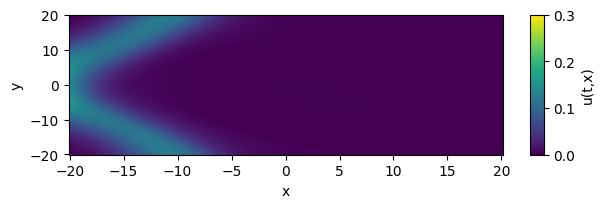

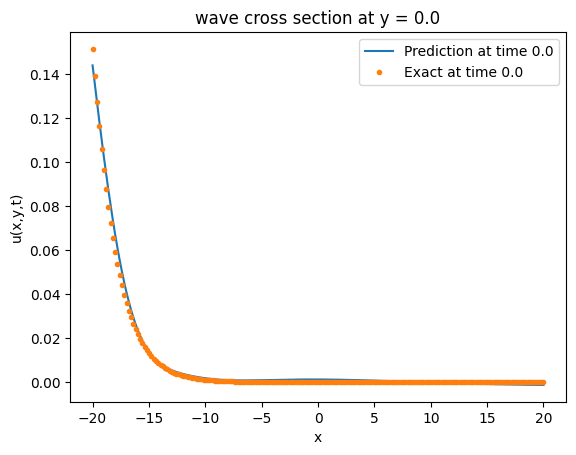

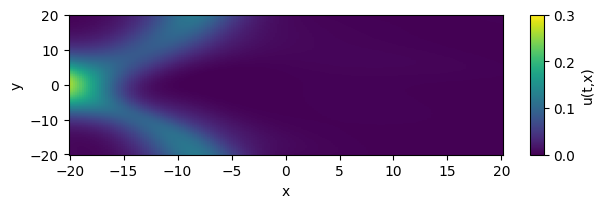

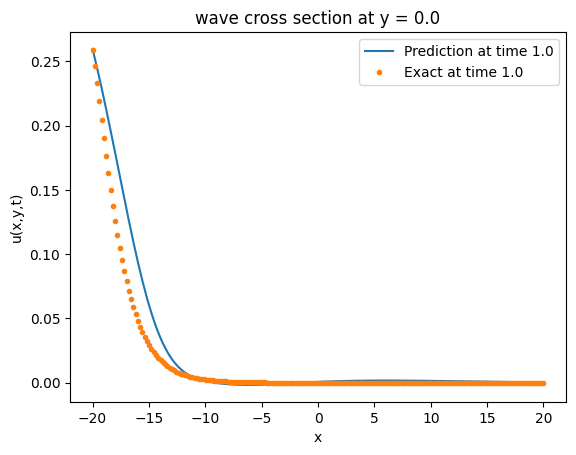

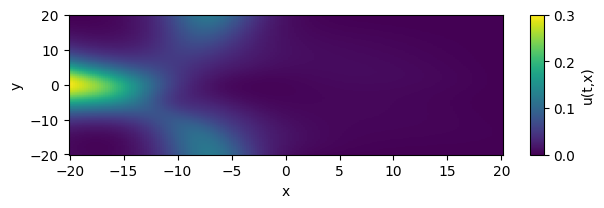

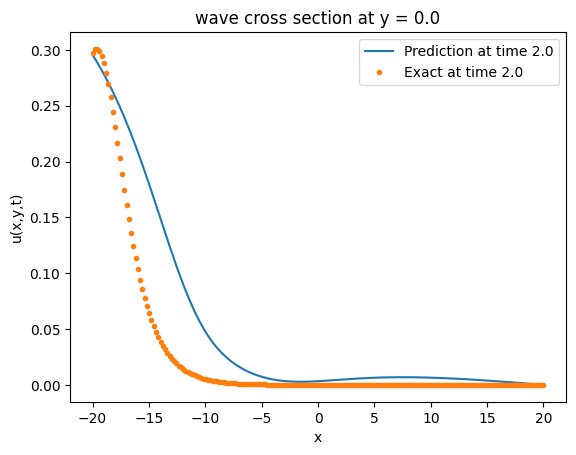

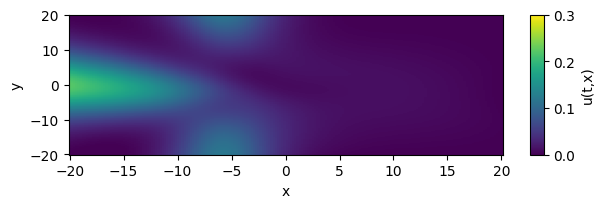

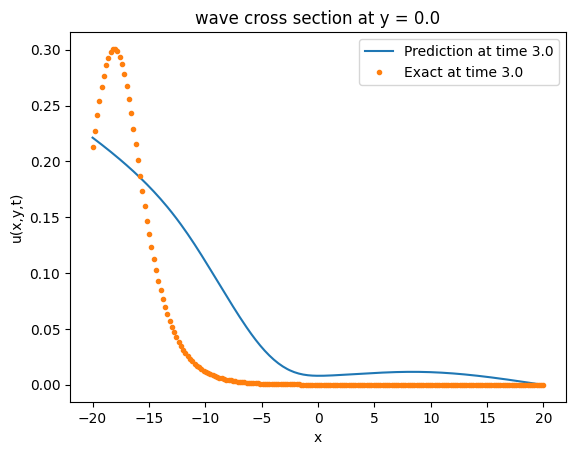

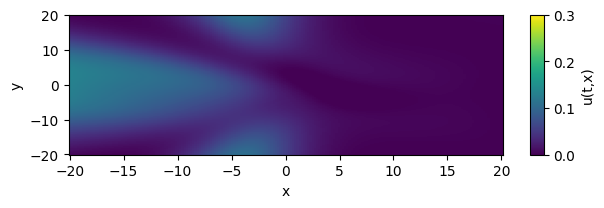

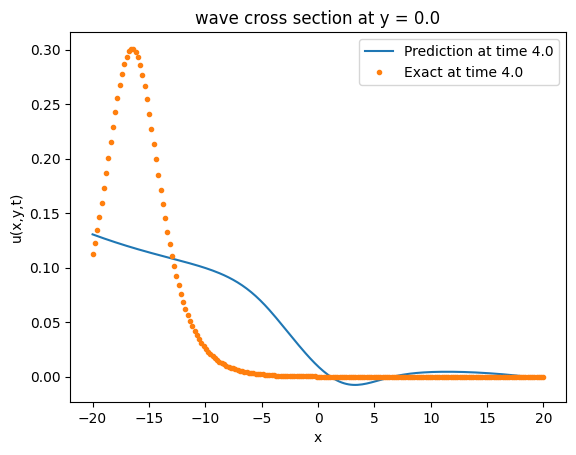

In [22]:

u2pinn, xpinn = plot_snapshots(np.arange(0,time+1.,1), phi_function = phi_function2, cross_sect = 0.)

In [ ]:
# put the images into the frames variable
import imageio
frames = []
timesGIF = np.arange(0,7+1,1)
for t, tt in enumerate(timesGIF):
    image = imageio.v2.imread(str(os.getcwdb())[2:-1]+"/GIFs/KPIIYJunctionTime7/KPIIYJunction"+str(t)+'.png')
    frames.append(image)
    print(t)


0
1
2
3
4
5
6
7


In [ ]:
# convert frames to GIF
GIFpath = str(os.getcwdb())[2:-1]+'/GIFs/YConfigKPII.gif'
imageio.mimsave(GIFpath, # output gif
                frames,          # array of input frames
                fps = 5)         # optional: frames per second

In [ ]:
import pickle
current_weights = pinn.backbone.get_weights()
with open('KPPinnTime15.pickle', 'wb') as f:
    pickle.dump(current_weights, f)

### seq-2-seq Attempt

Epoch 1/800
15/15 [==============================] - 34s 26ms/step - loss_total: 0.1662 - loss_residual: 8.5375e-04 - loss_initial: 0.0373 - loss_boundary: 0.0640 - loss_boundary_y: 0.0640 - mean_absolute_error: 0.1445
Epoch 2/800
15/15 [==============================] - 0s 24ms/step - loss_total: 0.0187 - loss_residual: 2.8022e-04 - loss_initial: 0.0030 - loss_boundary: 0.0078 - loss_boundary_y: 0.0076 - mean_absolute_error: 0.0491
Epoch 3/800
15/15 [==============================] - 0s 26ms/step - loss_total: 0.0086 - loss_residual: 2.5015e-04 - loss_initial: 0.0019 - loss_boundary: 0.0033 - loss_boundary_y: 0.0031 - mean_absolute_error: 0.0384
Epoch 4/800
15/15 [==============================] - 0s 23ms/step - loss_total: 0.0059 - loss_residual: 2.1773e-04 - loss_initial: 9.2619e-04 - loss_boundary: 0.0030 - loss_boundary_y: 0.0018 - mean_absolute_error: 0.0306
Epoch 5/800
15/15 [==============================] - 0s 27ms/step - loss_total: 0.0051 - loss_residual: 1.6675e-04 - loss_i

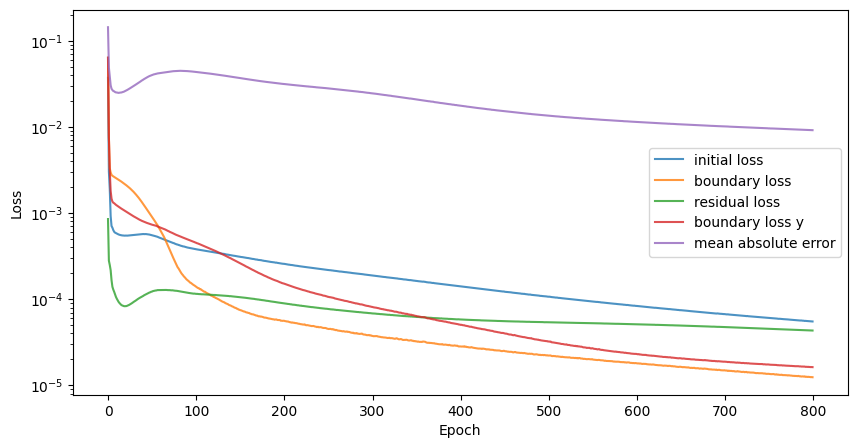

1/1 [==============================] - 0s 17ms/step


<Figure size 640x480 with 0 Axes>

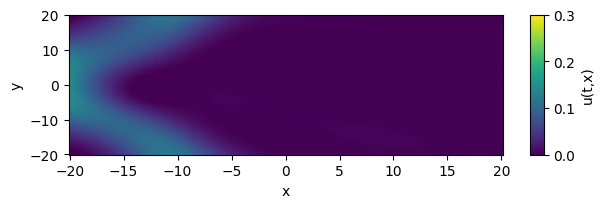

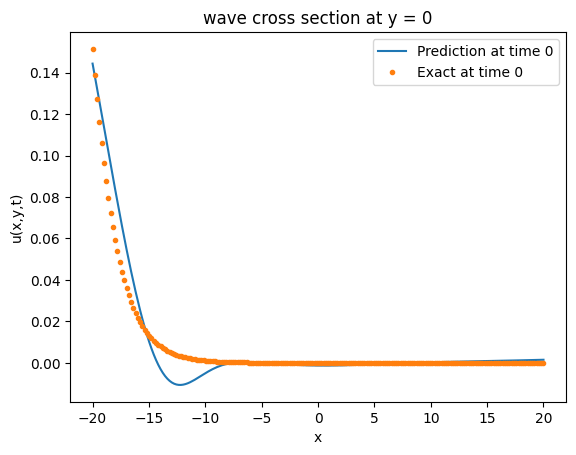

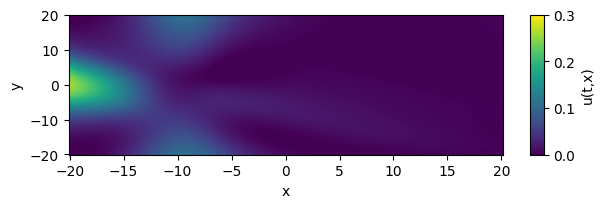

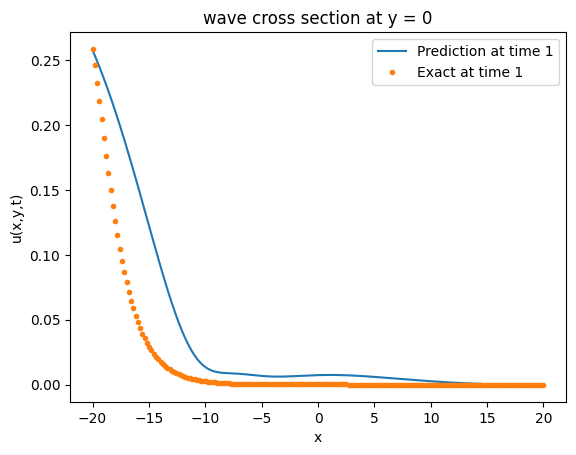

In [ ]:
# generate 75k for every time step till 0-1
# initialize pinn
# fit the pinn
# train for 500 epochs?
# save loss photos and weights
# change inputs and outputs
# go for the next time step.
x_start =  -20. #-10
length = 20.#10
y_start = x_start
ylength = length

time = 1
# when boundary function is set to None, the data will be collected from the phi_function but at boundary
(txy_eqn, u_eqn), (txy_init, u_phi), (txy_boundary_x, u_bnd_x), (txy_boundary_y, u_bnd_y), (x_bnd_left, x_bnd_right), (y_bnd_left, y_bnd_right)  = \
simulate_KP(75000, phi_function, None, time, x_start, length, y_start, ylength, n_bnds = None, n_init = None, random_seed = 42, dtype=tf.float32)
normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(txy_eqn)

inputs = [txy_eqn, txy_init, txy_boundary_x, x_bnd_right, x_bnd_left, txy_boundary_y, y_bnd_right, y_bnd_left]
outputs = [phi_function(txy_eqn), u_eqn, u_phi, u_bnd_x, u_bnd_y]

backbone = create_dense_model_Normalized([12, 24, 24, 24, 24, 12] , activation= 'tanh', initializer='glorot_normal', \
    n_inputs=3, n_outputs=1, normalizer=normalizer)
pinn = KPPinn(backbone, k=6., sig_sq = +3., PBC_y = False)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.85)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)



history = pinn.fit(inputs, outputs, batch_size = 5000, epochs = 800, verbose ='auto')


plot_training_loss(history.history, y_scale='log')
plt.savefig(str(os.getcwdb())[2:-1]+"/KPSeq2SeqXJunction/Loss"+str(-1)+".png", format="png", bbox_inches="tight")

plot_snapshots([0,1], cross_sect = 0)
current_weights = pinn.backbone.get_weights()
with open('KPSeq2SeqXJunction/test.pickle', 'wb') as f:
    pickle.dump(current_weights, f)
# with open('/KPSeq2SeqXJunction/test.pickle', 'rb') as f:
#     my_weights = pickle.load(f)

# pinn.backbone.set_weights(my_weights)

1/1 [==============================] - 0s 80ms/step
Epoch 1/800
15/15 [==============================] - 34s 24ms/step - loss_total: 0.0066 - loss_residual: 8.6647e-05 - loss_initial: 0.0016 - loss_boundary: 0.0022 - loss_boundary_y: 0.0027 - mean_absolute_error: 0.0379
Epoch 2/800
15/15 [==============================] - 0s 26ms/step - loss_total: 0.0018 - loss_residual: 7.7547e-05 - loss_initial: 3.2143e-04 - loss_boundary: 6.5091e-04 - loss_boundary_y: 7.1728e-04 - mean_absolute_error: 0.0251
Epoch 3/800
15/15 [==============================] - 0s 27ms/step - loss_total: 7.4700e-04 - loss_residual: 7.3495e-05 - loss_initial: 8.5063e-05 - loss_boundary: 3.1004e-04 - loss_boundary_y: 2.7840e-04 - mean_absolute_error: 0.0201
Epoch 4/800
15/15 [==============================] - 0s 24ms/step - loss_total: 5.3676e-04 - loss_residual: 7.2521e-05 - loss_initial: 4.6699e-05 - loss_boundary: 2.3060e-04 - loss_boundary_y: 1.8693e-04 - mean_absolute_error: 0.0200
Epoch 5/800
15/15 [============

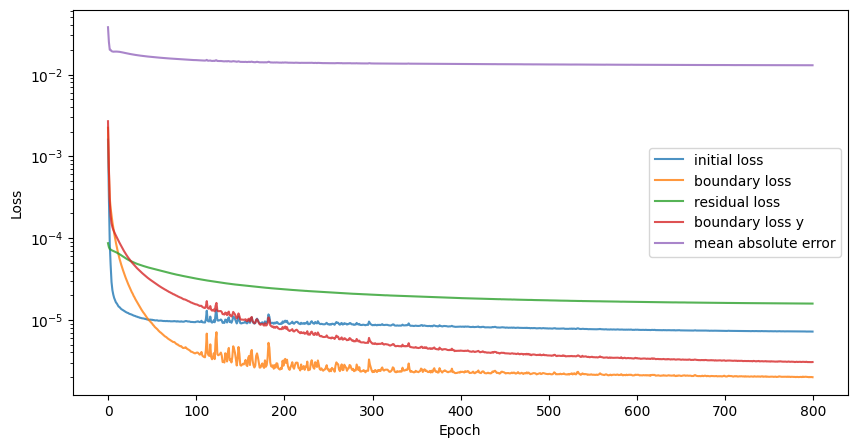

1/1 [==============================] - 0s 79ms/step
Epoch 1/800
15/15 [==============================] - 35s 25ms/step - loss_total: 0.0039 - loss_residual: 1.3810e-05 - loss_initial: 0.0010 - loss_boundary: 0.0018 - loss_boundary_y: 0.0010 - mean_absolute_error: 0.0260
Epoch 2/800
15/15 [==============================] - 0s 25ms/step - loss_total: 7.1585e-04 - loss_residual: 1.3844e-05 - loss_initial: 1.9556e-04 - loss_boundary: 2.7575e-04 - loss_boundary_y: 2.3069e-04 - mean_absolute_error: 0.0184
Epoch 3/800
15/15 [==============================] - 0s 24ms/step - loss_total: 2.3427e-04 - loss_residual: 1.4402e-05 - loss_initial: 6.1842e-05 - loss_boundary: 9.1868e-05 - loss_boundary_y: 6.6154e-05 - mean_absolute_error: 0.0140
Epoch 4/800
15/15 [==============================] - 0s 24ms/step - loss_total: 1.2002e-04 - loss_residual: 1.3441e-05 - loss_initial: 2.9092e-05 - loss_boundary: 3.4490e-05 - loss_boundary_y: 4.2995e-05 - mean_absolute_error: 0.0135
Epoch 5/800
15/15 [========

<Figure size 640x480 with 0 Axes>

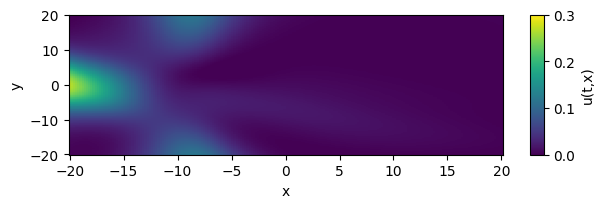

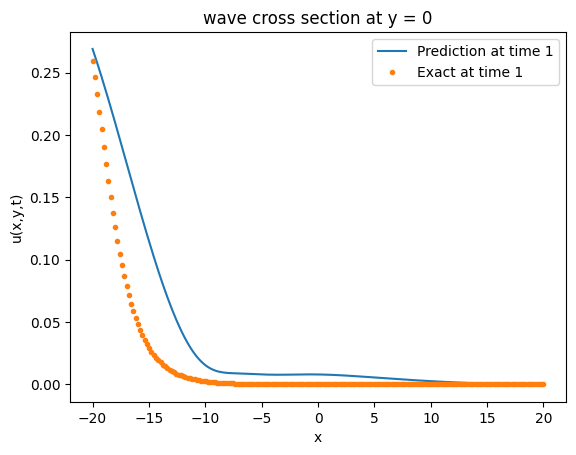

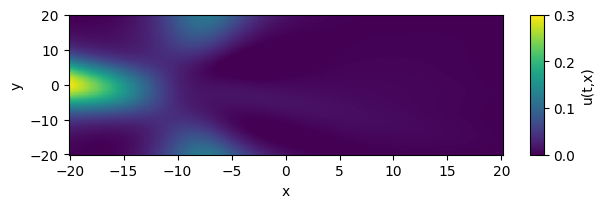

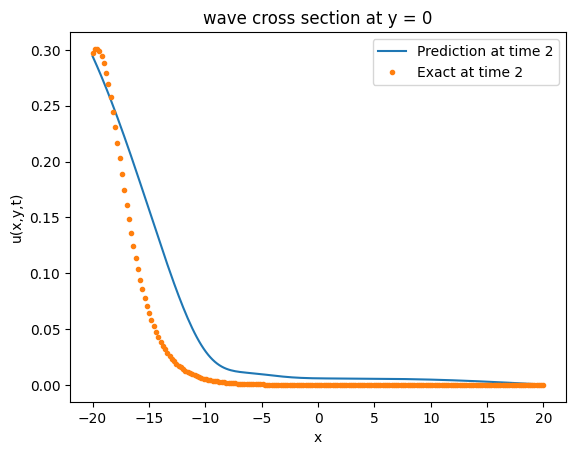

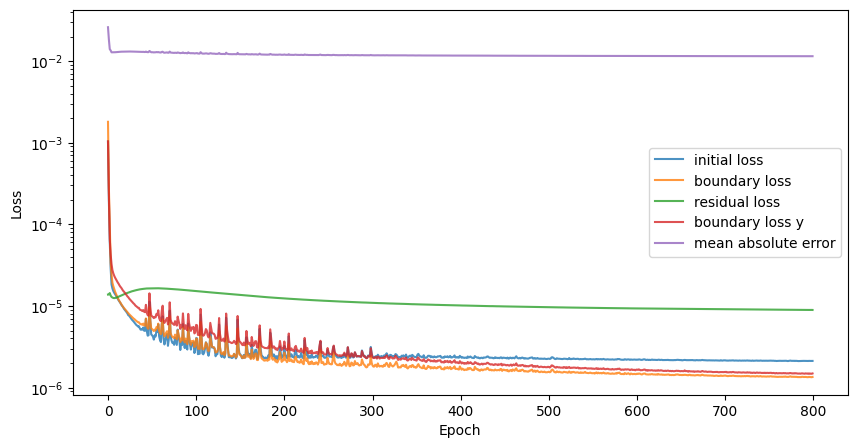

1/1 [==============================] - 0s 79ms/step
Epoch 1/800
15/15 [==============================] - 35s 24ms/step - loss_total: 0.0061 - loss_residual: 1.0094e-05 - loss_initial: 0.0017 - loss_boundary: 0.0026 - loss_boundary_y: 0.0017 - mean_absolute_error: 0.0363
Epoch 2/800
15/15 [==============================] - 0s 23ms/step - loss_total: 0.0013 - loss_residual: 8.4528e-06 - loss_initial: 3.1502e-04 - loss_boundary: 4.5546e-04 - loss_boundary_y: 4.7365e-04 - mean_absolute_error: 0.0211
Epoch 3/800
15/15 [==============================] - 0s 24ms/step - loss_total: 3.2468e-04 - loss_residual: 8.1433e-06 - loss_initial: 8.0644e-05 - loss_boundary: 1.4451e-04 - loss_boundary_y: 9.1385e-05 - mean_absolute_error: 0.0166
Epoch 4/800
15/15 [==============================] - 0s 23ms/step - loss_total: 1.3897e-04 - loss_residual: 7.9638e-06 - loss_initial: 2.3907e-05 - loss_boundary: 7.3520e-05 - loss_boundary_y: 3.3578e-05 - mean_absolute_error: 0.0149
Epoch 5/800
15/15 [============

<Figure size 640x480 with 0 Axes>

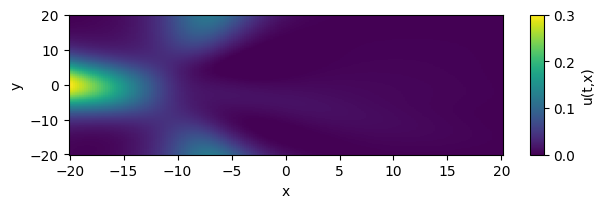

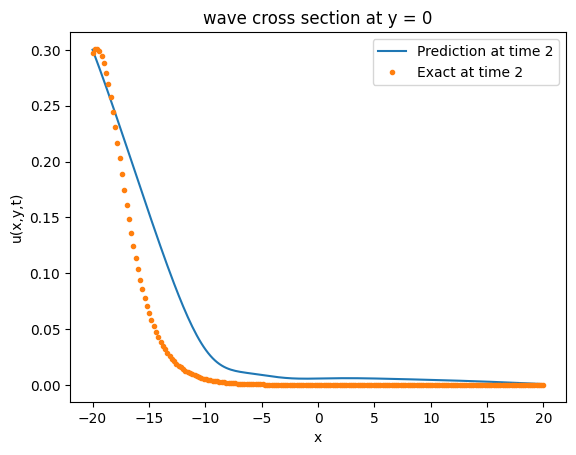

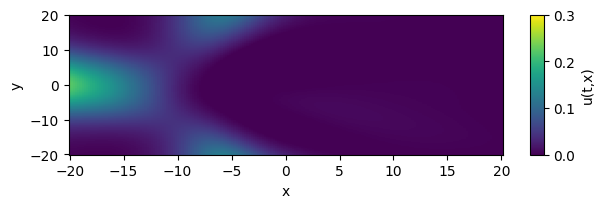

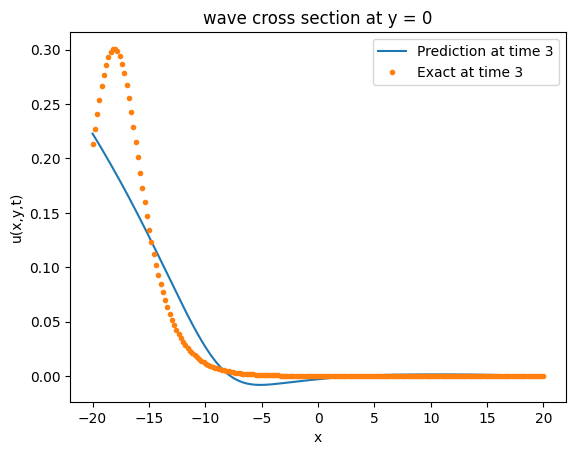

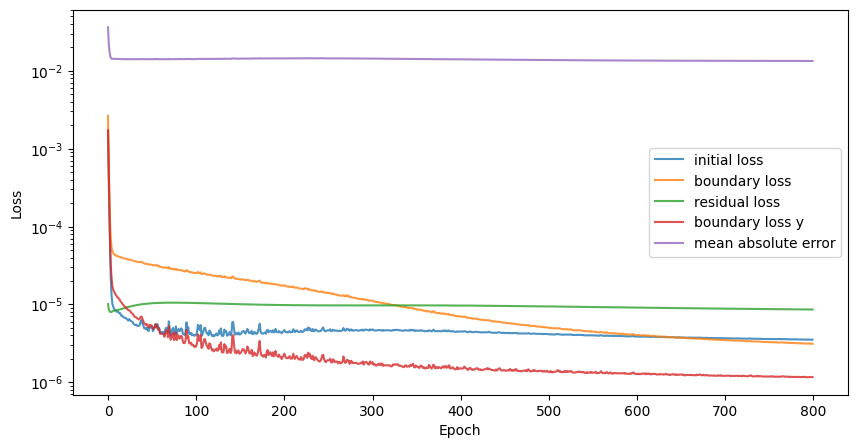

1/1 [==============================] - 0s 84ms/step
Epoch 1/800
15/15 [==============================] - 35s 25ms/step - loss_total: 0.0042 - loss_residual: 1.4602e-05 - loss_initial: 0.0013 - loss_boundary: 0.0017 - loss_boundary_y: 0.0012 - mean_absolute_error: 0.0308
Epoch 2/800
15/15 [==============================] - 0s 25ms/step - loss_total: 7.8460e-04 - loss_residual: 1.4937e-05 - loss_initial: 2.2189e-04 - loss_boundary: 2.5400e-04 - loss_boundary_y: 2.9378e-04 - mean_absolute_error: 0.0216
Epoch 3/800
15/15 [==============================] - 0s 24ms/step - loss_total: 2.5510e-04 - loss_residual: 1.6627e-05 - loss_initial: 6.5772e-05 - loss_boundary: 1.0485e-04 - loss_boundary_y: 6.7845e-05 - mean_absolute_error: 0.0202
Epoch 4/800
15/15 [==============================] - 0s 23ms/step - loss_total: 1.0128e-04 - loss_residual: 1.7105e-05 - loss_initial: 1.8923e-05 - loss_boundary: 3.8609e-05 - loss_boundary_y: 2.6639e-05 - mean_absolute_error: 0.0186
Epoch 5/800
15/15 [========

<Figure size 640x480 with 0 Axes>

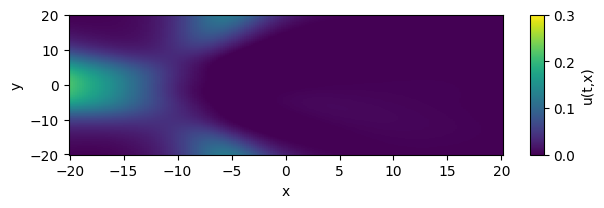

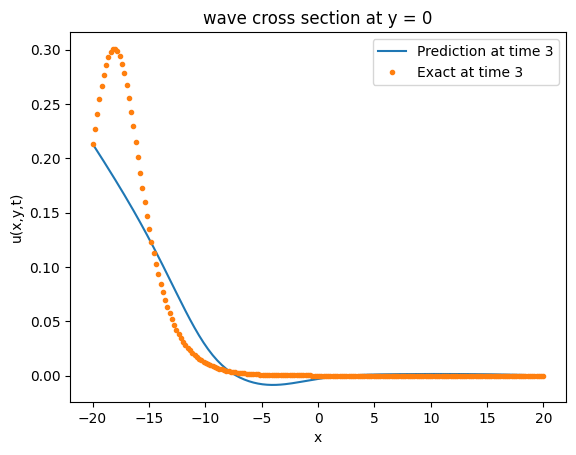

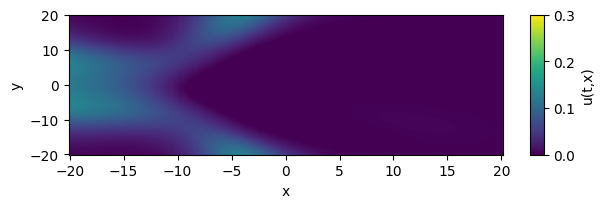

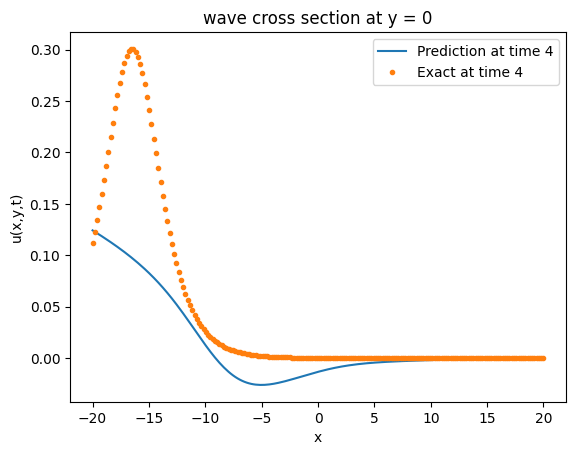

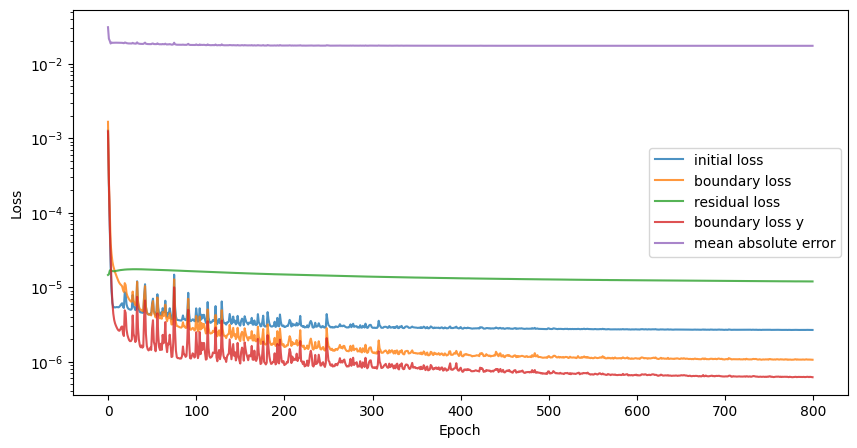

1/1 [==============================] - 0s 18ms/step


<Figure size 640x480 with 0 Axes>

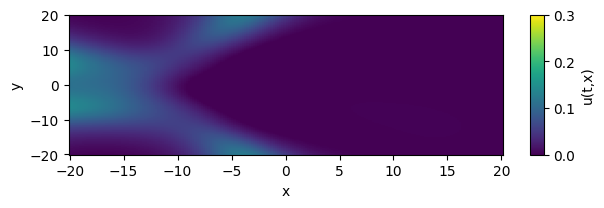

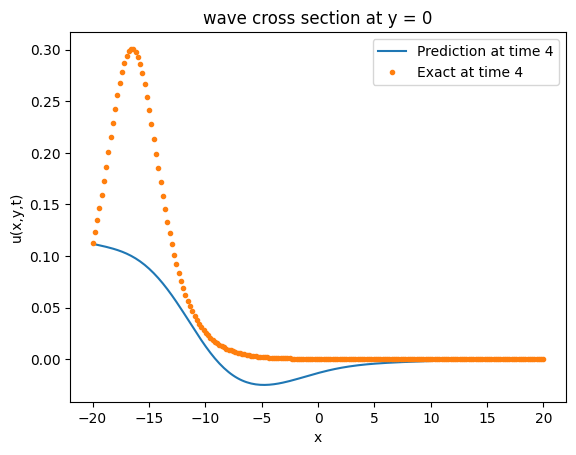

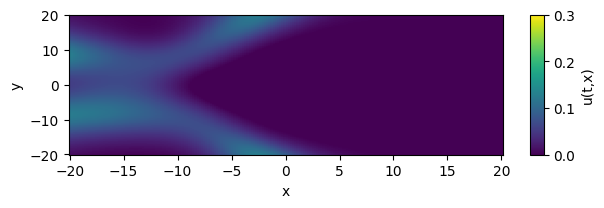

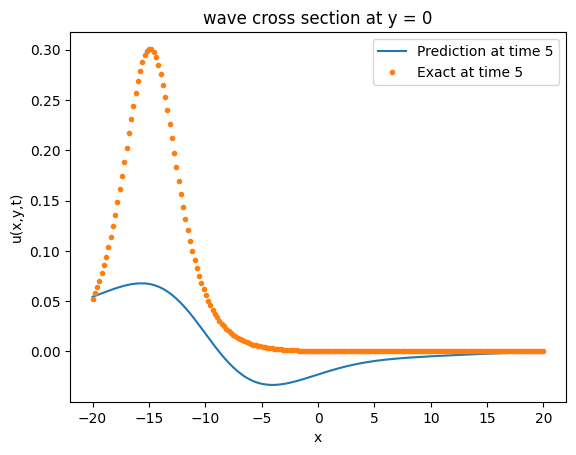

In [ ]:
for i in range(1,5):
  time = 1 + i
  (txy_eqn, u_eqn), (txy_init, u_phi), (txy_boundary_x, u_bnd_x), (txy_boundary_y, u_bnd_y), (x_bnd_left, x_bnd_right), (y_bnd_left, y_bnd_right)  = \
  simulate_KP(75000, phi_function, None, time, x_start, length, y_start, ylength, n_bnds = None, n_init = None, tstart = time-1, random_seed = 42, dtype=tf.float32)
  normalizer = tf.keras.layers.Normalization(axis=1)
  normalizer.adapt(txy_eqn)
  u_phi = pinn.backbone.predict(txy_init, batch_size=75000)
  inputs = [txy_eqn, txy_init, txy_boundary_x, x_bnd_right, x_bnd_left, txy_boundary_y, y_bnd_right, y_bnd_left]
  outputs = [phi_function(txy_eqn), u_eqn, u_phi, u_bnd_x, u_bnd_y]

  backbone = create_dense_model_Normalized([12, 24, 24, 24, 24, 12] , activation= 'tanh', initializer='glorot_normal', \
  n_inputs=3, n_outputs=1, normalizer=normalizer)
  pinn = KPPinn(backbone, k=6., sig_sq = +3., PBC_y = False)
  scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.85)
  optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
  pinn.compile(optimizer=optimizer)

  with open('KPSeq2SeqXJunction/test'+str(i-1)+'.pickle', 'rb') as f:
    my_weights = pickle.load(f)

  pinn.backbone.set_weights(my_weights)
  history = pinn.fit(inputs, outputs, batch_size = 5000, epochs = 800, verbose ='auto')


  plot_training_loss(history.history, y_scale='log')
  plt.savefig(str(os.getcwdb())[2:-1]+"/KPSeq2SeqXJunction/Loss"+str(i)+".png", format="png", bbox_inches="tight")

  plot_snapshots([i,time], cross_sect = 0)
  current_weights = pinn.backbone.get_weights()
  with open('KPSeq2SeqXJunction/test'+str(i)+'.pickle', 'wb') as f:
      pickle.dump(current_weights, f)



(1000, 3)


Text(0.5, 1.0, 'wave cross section at y = 0')

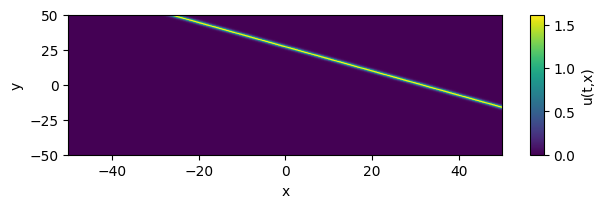

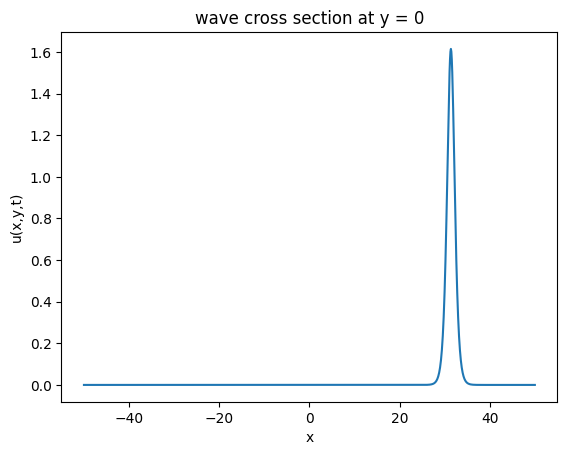

In [ ]:
ufrom matplotlib.gridspec import GridSpec
N = 1000
xt = np.linspace(x_start,length,N).T
yt = np.linspace(x_start,length,N).T
tt = np.zeros((N,1))
xt = xt.reshape(-1,1)
yt = yt.reshape(-1,1)
tt = tt.reshape(-1,1)

txy_test = np.c_[tt,xt,yt]
print(txy_test.shape)
txy_test = tf.convert_to_tensor(txy_test, dtype = 'float32')
txy_test = tf.reshape(txy_test, [N,3])
# (tf.shape(txy_test))
# plt.plot(txy_test[:,1:2], phi_function(txy_test))
TIME = 6
x, y = np.meshgrid(xt, yt)
txy = np.stack([np.full(x.flatten().shape, TIME), x.flatten(), y.flatten()],axis=-1)

fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 5)
plt.subplot(gs[0, :])

ut = phi_function(txy)
ut = tf.reshape(ut, [x.shape[0],x.shape[1]])
plt.pcolormesh(x, y, ut)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim( tf.reduce_min(ut), tf.reduce_max(ut))
fig = plt.figure()
cross_sect = 0
txy2 = np.stack([np.full(tt.shape, TIME),  xt , np.full(tt.shape, cross_sect)], axis=1)
u2 = phi_function(txy2)
u2 = tf.reshape(u2, [xt.shape[0],xt.shape[1]])
plt.plot(xt, u2, label = 'prediction at time {}'.format(0))
plt.xlabel('x')
plt.ylabel('u(x,y,t)')
plt.title('wave cross section at y = {}'.format(cross_sect))




